## Pre-selection with MACE

Run `mace_uncertainty.py` to postprocess the trajectory generated by lammps, calculating the MACE uncertainty on the forces as the standard deviation of the predictions of an ensemble.

To run the notebook, we use the trajectory reported in the DEAL paper for [Nitrogen decomposition](`../1_activelearning_N2/`).

In [23]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from ase import Atom
from ase.io import read, write

Load trajectory

In [24]:
folder = '../../1_activelearning_N2/a_input/'
!cd {folder} && bash get_data.sh

traj = read(f'{folder}/traj-std-ev10.xyz',index=':')
len(traj)

Trajectory file already present, skipping download.


3001

Analyze uncertainty distribution

In [25]:
# Define utils functions

def average_along_cv(value, cv, bins):
    h1,x = np.histogram(cv,bins=bins,weights=value)
    h2,_ = np.histogram(cv,bins=bins)

    mean = h1/h2
    x = (x[:-1]+x[1:])/2

    return x,mean

def compute_histogram(value, bins, threshold = None):
    h1,x = np.histogram(value,bins=bins)
    x = (x[:-1]+x[1:])/2

    if threshold is not None:
        h2,_ = np.histogram(value[(value>threshold)],bins=bins)
        return x,(h1,h2)
    else:
        return x,h1

In [26]:
# define uncertainty of the configs as the max uncertainty on force components
uncertainty_key = 'force_std_comp_max' # key of array

for atoms in traj:
    atoms.info['uncertainty'] = atoms.get_array(uncertainty_key).max()

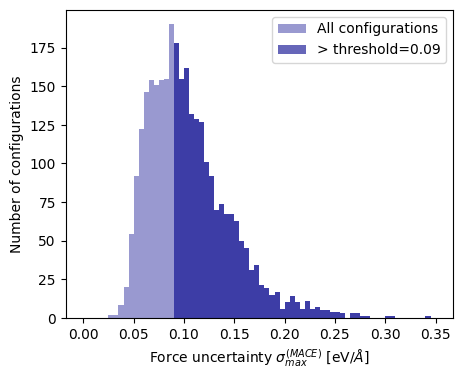

In [27]:
# plot histogram
unc = np.asarray([atoms.info['uncertainty'] for atoms in traj])

bins_unc = np.linspace(0, 0.35, 71)

threshold = 0.09

x,(h1,h2) = compute_histogram(unc,bins_unc,threshold=threshold)
fig, ax = plt.subplots(figsize=(5,4),dpi=100)
ax.bar(x,h1,width=(x[1]-x[0]),color='darkblue',alpha=0.4,label='All configurations')
ax.bar(x,h2,width=(x[1]-x[0]),color='darkblue',alpha=0.6,label=f'> threshold={threshold}')
ax.set_xlabel(r'Force uncertainty $\sigma^{(MACE)}_{max}$ [eV/$\AA$]')
ax.set_ylabel('Number of configurations')
ax.legend(frameon=True)
plt.show()

We can calculate a collective variable for each frame using ASE

In [ ]:
# Simple function to calculate CV (N-N distance)

def calculate_cv(traj):
    dist = lambda atoms: atoms[atoms.get_atomic_numbers()==7].get_distance(0,1,mic=True)

    if isinstance(traj[0],Atom):
        traj = [traj]
        
    return np.asarray( [dist(atoms) for atoms in traj])

# define bins for CV
cv = calculate_cv(traj)

Otherwise one can postprocess with PLUMED and read the COLVAR file

In [38]:
from deal.utils import load_dataframe

colvar = load_dataframe(f'{folder}/COLVAR')

for i,atoms in enumerate(traj):
    for col in colvar.columns:
        atoms.info['colvar.'+col] = colvar[col].iloc[i]

colvar

,time,coord_Co-Fe,coord_Co-N,coord_Fe-N,dist_N-N,walker
0,0.0,909.672941,6.840348,8.039158,2.860000,0
1,1.0,911.566457,8.090746,9.031735,3.170941,0
2,2.0,902.426518,7.771793,8.485276,3.252242,0
3,3.0,899.776088,7.600493,8.571635,2.971926,0
4,4.0,901.665373,6.635382,7.309394,1.953947,0
...,...,...,...,...,...,...
2996,2996.0,905.339467,6.936880,7.915974,3.243602,0
2997,2997.0,904.952976,7.049138,8.058686,2.893873,0
2998,2998.0,903.516148,7.353886,8.438719,2.963127,0
2999,2999.0,903.878526,7.598940,8.682715,2.970138,0


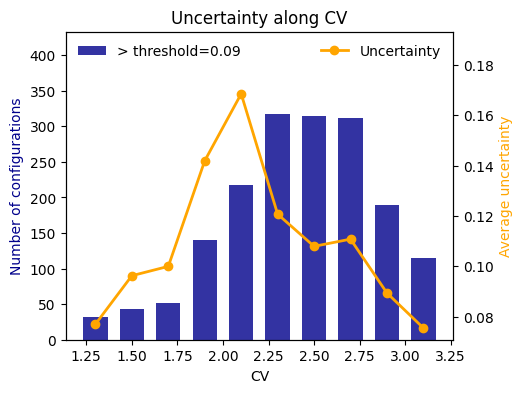

In [45]:
# plot histogram CV
cv = np.asarray([atoms.info['colvar.dist_N-N'] for atoms in traj])
bins_cv = np.linspace(1.2,3.2,11)
fig, axr = plt.subplots(figsize=(5,4),dpi=100)

# plot number of configurations > threshold
x,h1 = compute_histogram(cv,bins_cv)
x,h2 = compute_histogram(cv[unc>threshold],bins_cv)
#axr.bar(x, h1, width=(x[1]-x[0])/1.5, color='darkblue',zorder=0,alpha=0.4,label='All configurations')
axr.bar(x, h2, width=(x[1]-x[0])/1.5, color='darkblue',zorder=1,alpha=0.8,label=f'> threshold={threshold}' )

axr.set_xlabel('CV')
axr.set_ylabel('Number of configurations',color='darkblue')
axr.set_ylim(0,axr.get_ylim()[1]+100)
leg = axr.legend(fancybox=True, framealpha=0.7,loc='upper left')
leg.get_frame().set_linewidth(0.0)

# plot average uncertainty along CV
ax = axr.twinx()
_, unc_cv = average_along_cv(unc,cv,bins_cv)
ax.plot(x, unc_cv, color='orange',marker='o',zorder=2,linewidth=2, label='Uncertainty')

ax.set_ylabel('Average uncertainty',color='orange')
ax.set_ylim(None,ax.get_ylim()[1]+0.02)
leg = ax.legend(fancybox=True, framealpha=0.7,loc='upper right')
leg.get_frame().set_linewidth(0.0)
ax.set_title('Uncertainty along CV')
plt.show()

### Filtering

We can filter the samples based on :
* the uncertainty (`unc>threshold` and `unc<max_threshold` to avoid unphysical configurations)
* the CV (binning the space and selecting at most `max_samples_per_bin`)

In [46]:
def filter_by_uncertainty(traj,uncertainty=None,threshold=0.1,max_threshold=0.5):
    """
    Filter atoms objects in `traj` by uncertainty.

    Parameters
    ----------
    traj : list
        List of atoms objects
    uncertainty : array_like
        Uncertainty of each frame in `traj`, if not given use atoms.info['uncertainty']
    threshold : float
        Min uncertainty that trigger selection
    max_threshold : float, optional
        Max uncertainty to include.

    Returns
    -------
    filtered_traj : list
        List of atoms objects with uncertainty > `threshold`
        and uncertainty < `max_threshold`
    """
    if uncertainty is None:
        uncertainty = np.array([atoms.info['uncertainty'] for atoms in traj])
    sel = (uncertainty>threshold) & (uncertainty<max_threshold)
    return [atoms for s,atoms in zip(sel,traj) if s]

In [47]:
max_threshold = 0.3

print('Initial traj:',len(traj),'\n')

traj_filter = filter_by_uncertainty(traj,threshold=threshold,max_threshold=max_threshold)
print('--> Filter by uncertainty:',len(traj_filter),'\n')

Initial traj: 3001 

--> Filter by uncertainty: 1748 



In [48]:
def filter_by_cv(traj,cv,bins,max_samples_per_bin=1000, verbose=True):
    """
    Filter atoms objects in `traj` by binning in collective variable `cv`.

    Parameters
    ----------
    traj : list
        List of atoms objects
    cv : string or array_like
        Collective variable for each frame in `traj`, if a string is given
        it is read from atoms.info[cv]
    bins : array_like
        Bins for CV
    max_samples_per_bin : int, optional
        Maximum number of samples to keep in each bin. Default is 1000
    verbose : bool, optional
        Print out the distribution of CV. Default is True

    Returns
    -------
    filtered_traj : list
        List of atoms objects, with `max_samples_per_bin` samples per bin
    """
    if type(cv) == str:
        cv = np.array([atoms.info[cv] for atoms in traj])
        
    indexes = []
    if verbose: 
        print( 'CV distribution' )
    for i in range(len(bins)-1):
        sel = (cv>bins[i]) & (cv<bins[i+1])
        index = np.argwhere(sel).ravel()
        
        if len(index) > max_samples_per_bin:
            index = np.random.choice(index,max_samples_per_bin,replace=False)

        if verbose:
            print(f'{bins[i]:.2f} < cv < {bins[i+1]:.2f} : {np.sum(sel)} --> {len(index)}')

        indexes.extend(index)

    return [traj[i] for i in indexes]

In [50]:
max_samples_per_bin = 100

traj_filter = filter_by_cv(traj_filter,cv='colvar.dist_N-N',bins=bins_cv,max_samples_per_bin=max_samples_per_bin)
print('\n--> Filter by CV:',len(traj_filter))

CV distribution
1.20 < cv < 1.40 : 32 --> 32
1.40 < cv < 1.60 : 43 --> 43
1.60 < cv < 1.80 : 52 --> 52
1.80 < cv < 2.00 : 140 --> 100
2.00 < cv < 2.20 : 215 --> 100
2.20 < cv < 2.40 : 317 --> 100
2.40 < cv < 2.60 : 314 --> 100
2.60 < cv < 2.80 : 312 --> 100
2.80 < cv < 3.00 : 190 --> 100
3.00 < cv < 3.20 : 115 --> 100

--> Filter by CV: 827


Save the trajectory to be used as input for DEAL

In [51]:
write('traj_preselection.xyz',traj_filter)

/home/lbonati@iit.local/software/miniforge3-mamba/envs/deal/lib/python3.12/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
